# TP2 Prévision de consommation avec réseau de neurones


<img src="pictures/Présentation_FormationIA_TPDeepLearning.png" width=1000 height=60>

**Dans l'épisode précédent**  

Nos modèles de régression du TP1 nous ont donné des premiers résultats et des premières intuitions sur notre problème de prévision de consommation pour le lendemain. 

Nous avons pu analyser des profils de courbe de consommation au jour, à la semaine, au mois. Nous avons également observé la dépendance entre la consommation et la consommation retardée. Nous avons aussi vu l'impact des jours fériés. 

Nous avons ensuite utilisé de premiers modèles en machine learning pour apprendre par observations l'influence de différents contextes sur la consommation sans les décrires explicitement selon des lois. Nous sommes arrivés à une erreur moyenne de test de 2,8%, bien mieux que ce qui avait été obtenu via une approche naïve.

Des difficultés se sont posées pour intégrer les variables météorologiques très dépendantes entre elles et pour intégrer un vecteur de consommation retardée.

Avec l'approche classique exposée dans ce TP1, nous avons en particulier constaté le besoin d'une expertise et d'un travail autour des variables explicatives pour obtenir un modèle performant.

**Aujourd'hui** 

Nous allons de nouveau nous attaquer à ce sujet de la prévision de consommation nationale pour le lendemain, mais cette fois en utilisant un modèle de prévision par réseau de neurones. Nous allons exploiter leur capacité à capter ces phénomènes non-linéaires et interdépendants. Nous allons mettre en évidence le moindre besoin en feature engineering en travaillant directement à la granularité de la donnée, sans créer de variables agrégées ou transformées par de l'expertise.

**Ce que vous allez voir dans ce second TP**

- Un rappel de notre problème et récapitulatif des performances de nos modèles précédents
- Une nouvelle méthode numérique pour préparer ses données et faciliter l'apprentissage : la normalisation
- La création d'un premier réseau de neurones pour prédire la consommation dans 24h
- L'utilisation de tensorboard pour observer en temps réel la courbe d'apprentissage du réseau de neurones
- La création de modèles de plus en plus performants en intégrant davantage d'informations dans notre modélisation
- L'évaluation des modèles sur 2 types de jeux de test

**Ce que vous allez devoir faire**

- Compléter les quelques trous de codes que nous vous avons laissé si vous le souhaitez. La solution est disponible dans le TP complété.
- Répondre aux quelques questions disséminées dans ce TP
- Entrainer votre propre modèle pour améliorer les performances d'un modèle existant et essayer de remporter notre mini-challenge !

__NB__ : Pour ce TP nous utiliserons Keras, une bibliothèque python de haut niveau qui appelle des fonctions de la librairie TensorFlow. D'autres librairies existent, Keras a été retenue en raison de sa facilité d'utilisation.

# Dimensionnement en temps
La durée estimée de ce TP est d'environ 1h30 :
- 10-20 minutes pour charger et préparer les données pour les réseaux de neurones 
- 10-20 minutes pour entrainer un premier modèle de réseau de neurones, en examiner le code implémentant ce réseau de neurones
- Le reste pour jouer et tenter d'améliorer la qualité de la prédiction avec de nouvelles variables explicatives, ou en choisissant d'autres hyper-paramètres. 

# I) Préparation des données

## Chargement des librairies nécessaires

In [62]:
import os
import numpy as np
import pandas as pd
import random
import datetime
import zipfile
import math
from time import time

import plotly
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

# sklearn est la librairie de machine learning en python et scipy une librairie statistiques
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from scipy import stats

# Keras est la librairie que nous utilisons pour se créer des modèles de réseau de neurones
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils import plot_model
from keras.utils.data_utils import get_file
from keras.utils.vis_utils import model_to_dot
from keras.applications.imagenet_utils import preprocess_input
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers import Input, Embedding, LSTM, Dense
from keras.callbacks import TensorBoard
from keras.optimizers import Adam
import keras.backend as K
K.set_image_data_format('channels_last')

from IPython.display import SVG
%matplotlib inline

## I) Récupération et préparation des données

Dans cette partie nous allons charger les fichiers csv nécessaires pour l'analyse, puis les convertir en data-frame python. Les données de base à récupérer sont :
- la base de données issues du TP1 (Les historiques de consommation, leur lag, les données météo en température, leur lag, les jours feriés) 

En terme de transformation des données pour mieux les préparer:

- nous allons aussi voir comment normaliser les données, une transformation souvent bien utile en pratique pour une meilleure convergence numérique. 

Cela vient compléter les transformations vu précédemment pour les données calendaires, et aussi la transformation "one-hot" pour les données catégorielles

In [63]:
## Choix du répertoire de travail "data_folder" dans lequel toutes les fichiers csv seront entreposés
# a actualiser avec le repertoire par defaut sur le serveur
data_folder = os.path.join(os.getcwd(), "data")

## Petite vérification
print("Mon repertoire est : {}".format(data_folder))
print("Fichiers contenus dans ce répertoire :")
for file in os.listdir(data_folder):
    print(" - " + file)

Mon repertoire est : /home/clementrem/Documents/Formation_FIFA/TP_Formation_Conso_DeepLearning/data
Fichiers contenus dans ce répertoire :
 - Yconso.csv
 - Xinput.zip


### Récupération de nos variables à prédire: la consommation française

In [64]:
y_conso_csv = os.path.join(data_folder, "Yconso.csv")
y_conso_df = pd.read_csv(y_conso_csv, sep=",", engine='c', header=0)
y_conso_df.rename(columns={"y": "conso_nat_realisee"}, inplace=True)
y_conso_df['ds'] = pd.to_datetime(y_conso_df['ds'])
y_conso_df['ds'] = y_conso_df['ds'].dt.tz_localize(None)
display(y_conso_df.head(5))
print(y_conso_df.shape)

,ds,conso_nat_realisee
0,2014-01-08 00:00:00,62008
1,2014-01-08 01:00:00,57298
2,2014-01-08 02:00:00,56216
3,2014-01-08 03:00:00,53719
4,2014-01-08 04:00:00,51798


(43368, 2)


<font color='green'>

* Petit rappel, que fait la fonction "shape" ?

</font>

### Récupération de nos variables explicatives XInput du TP1

Les données météo sont confidentielles, et donc ont été cryptées. Pour les lire vous avez besoin d'un mot de passe qui ne peut vous être donné que dans le cadre d'un travail au sein de RTE.

In [65]:
password = "FIFA_Meteo"

On remarquera que ces données commencent au 8 janvier, alors que pour Xinput elles commencent au 1er janvier

In [66]:
# Récupération des températures et jours fériés
Xinput_zip = os.path.join(data_folder, "Xinput.zip")
zfXinput = zipfile.ZipFile(Xinput_zip)
zfXinput.setpassword(bytes(password,'utf-8'))
Xinput = pd.read_csv(zfXinput.open('Xinput.csv'),sep=",",engine='c',header=0)
Xinput['ds'] = pd.to_datetime(Xinput['ds'])
Xinput['ds'] = Xinput['ds'].dt.tz_localize(None)
Xinput = Xinput[['ds', 'holiday', 'Th_real_24h_avant', 'Th_prev']]

display(Xinput.head(5))
print(Xinput.shape)

,ds,holiday,Th_real_24h_avant,Th_prev
0,2014-01-08 00:00:00,NaN,9.84693,9.911160
1,2014-01-08 01:00:00,NaN,9.84850,9.790830
2,2014-01-08 02:00:00,NaN,9.68158,9.634990
3,2014-01-08 03:00:00,NaN,9.48713,9.445360
4,2014-01-08 04:00:00,NaN,9.49041,9.241585


(43368, 4)


### Fusion en une unique DataFrame

Ici chacun a sa méthode maison pour pré-traiter les données :-)  
Proposition personnelle : Fusionner le X et le Y dans une unique DataFrame aide à éviter des décalages d'indice.

In [67]:
working_df = pd.merge(Xinput, y_conso_df, how='inner', on="ds")

display(working_df.head(5))
print(working_df.shape)

,ds,holiday,Th_real_24h_avant,Th_prev,conso_nat_realisee
0,2014-01-08 00:00:00,NaN,9.84693,9.911160,62008
1,2014-01-08 01:00:00,NaN,9.84850,9.790830,57298
2,2014-01-08 02:00:00,NaN,9.68158,9.634990,56216
3,2014-01-08 03:00:00,NaN,9.48713,9.445360,53719
4,2014-01-08 04:00:00,NaN,9.49041,9.241585,51798


(43368, 5)


### Normalisation ("scaling")

En théorie, la normalisation des données d'entrée n'est pas indispensable pour entrainer un réseau de neurones.  

En effet, on devrait apprendre des poids et biais plus ou moins importants pour équilibrer les contributions des différentes variables explicatives en entrée. 

Cependant en pratique, normaliser les données d'entrée permet généralement d'obtenir un apprentissage plus rapide du réseau de neurones.

<br/>
<font color='green'>
    
* Comment l'expliquez-vous ?

<font>

In [68]:
columns_to_scale = ["Th_real_24h_avant", "Th_prev", "conso_nat_realisee"]
new_column_names = [x + "_scaled" for x in columns_to_scale]

scaler = StandardScaler()
scaler.fit(working_df[columns_to_scale])
scaled_values = scaler.transform(working_df[columns_to_scale])
scaled_values_df = pd.DataFrame(scaled_values, columns=new_column_names)

# Remarque en passant:
# Ne pas relancer cette cellule, sinon
# working_df va beaucoup grossir...
working_df = pd.concat([working_df, scaled_values_df], axis=1)

In [69]:
display(working_df.head(5))
print(working_df.shape)

# Petite verif manuelle
mean = np.mean(working_df["conso_nat_realisee"])
mean_scaled = np.mean(working_df["conso_nat_realisee_scaled"])
print()
print("--- Petite verif ---")
print("Moyenne de conso_nat_realisee: " + str(mean))
print("Moyenne de conso_nat_realisee_scaled: " + str(mean_scaled))

,ds,holiday,Th_real_24h_avant,Th_prev,conso_nat_realisee,Th_real_24h_avant_scaled,Th_prev_scaled,conso_nat_realisee_scaled
0,2014-01-08 00:00:00,NaN,9.84693,9.911160,62008,-0.468832,-0.459708,0.675608
1,2014-01-08 01:00:00,NaN,9.84850,9.790830,57298,-0.468599,-0.477569,0.277725
2,2014-01-08 02:00:00,NaN,9.68158,9.634990,56216,-0.493345,-0.500700,0.186322
3,2014-01-08 03:00:00,NaN,9.48713,9.445360,53719,-0.522172,-0.528847,-0.024615
4,2014-01-08 04:00:00,NaN,9.49041,9.241585,51798,-0.521685,-0.559094,-0.186893


(43368, 8)

--- Petite verif ---
Moyenne de conso_nat_realisee: 54010.37857406383
Moyenne de conso_nat_realisee_scaled: -9.175058384653572e-17


In [70]:
# Pour plus tard, on se garde de côté un scaler uniquement dénormaliser la prédiction de conso
scaler_conso_nat = StandardScaler()
scaler_conso_nat.fit(working_df[["conso_nat_realisee"]])

# Verif
scaler_conso_nat.inverse_transform(working_df["conso_nat_realisee_scaled"])

array([62008., 57298., 56216., ..., 68589., 65288., 67766.])

### Ajout des variables retardées

In [71]:
working_df['conso_nat_realisee_scaled_lag1H'] = working_df['conso_nat_realisee_scaled'].shift(1)
working_df['conso_nat_realisee_scaled_lag1D'] = working_df['conso_nat_realisee_scaled'].shift(24)
working_df['conso_nat_realisee_scaled_lag1W'] = working_df['conso_nat_realisee_scaled'].shift(24 * 7)

# Regardons
working_df.loc[[0, 1, 2, 3, 23, 24, 24 *7 -1, 24 * 7], :]

,ds,holiday,Th_real_24h_avant,Th_prev,conso_nat_realisee,Th_real_24h_avant_scaled,Th_prev_scaled,conso_nat_realisee_scaled,conso_nat_realisee_scaled_lag1H,conso_nat_realisee_scaled_lag1D,conso_nat_realisee_scaled_lag1W
0,2014-01-08 00:00:00,NaN,9.846930,9.911160,62008,-0.468832,-0.459708,0.675608,NaN,NaN,NaN
1,2014-01-08 01:00:00,NaN,9.848500,9.790830,57298,-0.468599,-0.477569,0.277725,0.675608,NaN,NaN
2,2014-01-08 02:00:00,NaN,9.681580,9.634990,56216,-0.493345,-0.500700,0.186322,0.277725,NaN,NaN
3,2014-01-08 03:00:00,NaN,9.487130,9.445360,53719,-0.522172,-0.528847,-0.024615,0.186322,NaN,NaN
23,2014-01-08 23:00:00,NaN,10.505480,9.971110,62721,-0.371202,-0.450810,0.735839,0.516286,NaN,NaN
24,2014-01-09 00:00:00,NaN,10.467205,9.898510,61752,-0.376876,-0.461586,0.653982,0.735839,0.675608,NaN
167,2014-01-14 23:00:00,NaN,5.760640,4.572135,70554,-1.074620,-1.252186,1.397540,1.159487,1.149265,NaN
168,2014-01-15 00:00:00,NaN,5.378660,4.479105,69280,-1.131248,-1.265995,1.289918,1.397540,1.043923,0.675608


<font color='blue'>

**Prenons quelques instants pour comprendre ces histoires de variables retardées.**

Imaginons que l'on veuille prédire la consommation nationale pour le point horaire cible du 09/01/2014 à 00h00 (ligne 24 de working_df)

Utiliser dans un modèle de prédiction :
* la consommation réalisée de la veille (08/01/2014 à 00h00)
* les infos de météo réalisée de la veille
* les **prévisions** météo du point horaire cible (09/01/2014 à 00h00)

semble être pertinent.

</font>
<br/>
  
<font color='green'>

* Est-ce que le shift a été fait dans le bon sens ?

</font>

### Encoding des jours fériés

In [72]:
working_df["is_bank_holiday"] = working_df["holiday"].astype("str").apply(lambda x: 0 if x == "nan" else 1)

# Regardons
display(working_df.loc[[0, 1, 2730], :])

,ds,holiday,Th_real_24h_avant,Th_prev,conso_nat_realisee,Th_real_24h_avant_scaled,Th_prev_scaled,conso_nat_realisee_scaled,conso_nat_realisee_scaled_lag1H,conso_nat_realisee_scaled_lag1D,conso_nat_realisee_scaled_lag1W,is_bank_holiday
0,2014-01-08 00:00:00,NaN,9.84693,9.91116,62008,-0.468832,-0.459708,0.675608,NaN,NaN,NaN,0
1,2014-01-08 01:00:00,NaN,9.84850,9.79083,57298,-0.468599,-0.477569,0.277725,0.675608,NaN,NaN,0
2730,2014-05-01 18:00:00,1erMai,14.84199,13.68148,40787,0.271681,0.099925,-1.117059,-1.178896,-0.288095,-0.2576,1


### Encoding de la date

Commençons par une étape intermédiaire, à savoir extraire de la colonne "ds" les informations qui nous intéressent.

In [73]:
working_df['month'] = working_df['ds'].dt.month
working_df['hour'] = working_df['ds'].dt.hour

# On sépare les jours de la semaine en week-end / pas week-end
# De base, la fonction datetime.weekday() renvoie 0 => Lundi, 2 => Mardi, ..., 5 => Samedi, 6 => Dimanche
# Ci-dessous, si on a un jour de la semaine alors dans la colonne weekday on mettra 1, et 0 si c'est le week-end
working_df['weekday'] = (working_df['ds'].dt.weekday < 5).astype(int)  # conversion bool => int

# Regardons
working_df.loc[[0, 1, 23, 24, 24 *7 -1, 24 * 7, 1100], :]

,ds,holiday,Th_real_24h_avant,Th_prev,conso_nat_realisee,Th_real_24h_avant_scaled,Th_prev_scaled,conso_nat_realisee_scaled,conso_nat_realisee_scaled_lag1H,conso_nat_realisee_scaled_lag1D,conso_nat_realisee_scaled_lag1W,is_bank_holiday,month,hour,weekday
0,2014-01-08 00:00:00,NaN,9.846930,9.911160,62008,-0.468832,-0.459708,0.675608,NaN,NaN,NaN,0,1,0,1
1,2014-01-08 01:00:00,NaN,9.848500,9.790830,57298,-0.468599,-0.477569,0.277725,0.675608,NaN,NaN,0,1,1,1
23,2014-01-08 23:00:00,NaN,10.505480,9.971110,62721,-0.371202,-0.450810,0.735839,0.516286,NaN,NaN,0,1,23,1
24,2014-01-09 00:00:00,NaN,10.467205,9.898510,61752,-0.376876,-0.461586,0.653982,0.735839,0.675608,NaN,0,1,0,1
167,2014-01-14 23:00:00,NaN,5.760640,4.572135,70554,-1.074620,-1.252186,1.397540,1.159487,1.149265,NaN,0,1,23,1
168,2014-01-15 00:00:00,NaN,5.378660,4.479105,69280,-1.131248,-1.265995,1.289918,1.397540,1.043923,0.675608,0,1,0,1
1100,2014-02-22 20:00:00,NaN,5.719350,7.398090,64689,-1.080741,-0.832726,0.902088,0.935710,1.439525,0.968064,0,2,20,0


Nous allons maintenant effectuer un "one-hot encoding" pour convertir ces informations sous un format utilisable par le réseau de neurones

In [74]:
encoded_month = pd.get_dummies(working_df['month'], prefix="month")
encoded_hour = pd.get_dummies(working_df['hour'], prefix="hour")

display(encoded_month.head(3))
display(encoded_hour.head(3))

,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,1,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0


,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [75]:
# De calculer cette cellule qu'une seule fois à cause du concat !
working_df = pd.concat([working_df, encoded_month, encoded_hour], axis=1)
working_df = working_df.drop(['month', 'hour'], axis=1)

In [76]:
display(working_df.head(3))

,ds,holiday,Th_real_24h_avant,Th_prev,conso_nat_realisee,Th_real_24h_avant_scaled,Th_prev_scaled,conso_nat_realisee_scaled,conso_nat_realisee_scaled_lag1H,conso_nat_realisee_scaled_lag1D,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,2014-01-08 00:00:00,NaN,9.84693,9.91116,62008,-0.468832,-0.459708,0.675608,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,2014-01-08 01:00:00,NaN,9.84850,9.79083,57298,-0.468599,-0.477569,0.277725,0.675608,NaN,...,0,0,0,0,0,0,0,0,0,0
2,2014-01-08 02:00:00,NaN,9.68158,9.63499,56216,-0.493345,-0.500700,0.186322,0.277725,NaN,...,0,0,0,0,0,0,0,0,0,0


### Menage : suppression des lignes avec des NaN

In [77]:
mask = working_df.drop(columns='holiday').isnull().any(axis=1)  # la colonne "holiday" contient des NaN mais n'est pas pertinente

print("Nombre de lignes avec NaN : " + str(np.sum(mask)))

Nombre de lignes avec NaN : 168


In [78]:
# On garde tout sauf les lignes avec des NaN
working_df = working_df[~mask]

### Séparation en un X et un Y propre pour le réseau de neurones

In [79]:
print(working_df.columns)

Index(['ds', 'holiday', 'Th_real_24h_avant', 'Th_prev', 'conso_nat_realisee',
       'Th_real_24h_avant_scaled', 'Th_prev_scaled',
       'conso_nat_realisee_scaled', 'conso_nat_realisee_scaled_lag1H',
       'conso_nat_realisee_scaled_lag1D', 'conso_nat_realisee_scaled_lag1W',
       'is_bank_holiday', 'weekday', 'month_1', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12', 'hour_0', 'hour_1', 'hour_2',
       'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9',
       'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15',
       'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21',
       'hour_22', 'hour_23'],
      dtype='object')


In [80]:
x_columns = ["ds", "is_bank_holiday", 'Th_real_24h_avant_scaled', 'Th_prev_scaled'] \
+ ['conso_nat_realisee_scaled_lag1H', 'conso_nat_realisee_scaled_lag1D', 'conso_nat_realisee_scaled_lag1W'] \
+ ["month_" + str(x) for x in range(1, 13)] \
+ ["hour_" + str(x) for x in range(0, 24)] \
+ ["weekday"]

y_columns = ["ds", "conso_nat_realisee", "conso_nat_realisee_scaled"]

In [81]:
X = working_df[x_columns]
Y = working_df[y_columns]

In [82]:
display(X.head(3))
print(X.shape)

,ds,is_bank_holiday,Th_real_24h_avant_scaled,Th_prev_scaled,conso_nat_realisee_scaled_lag1H,conso_nat_realisee_scaled_lag1D,conso_nat_realisee_scaled_lag1W,month_1,month_2,month_3,...,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,weekday
168,2014-01-15 00:00:00,0,-1.131248,-1.265995,1.397540,1.043923,0.675608,1,0,0,...,0,0,0,0,0,0,0,0,0,1
169,2014-01-15 01:00:00,0,-1.161552,-1.264590,1.289918,0.671384,0.277725,1,0,0,...,0,0,0,0,0,0,0,0,0,1
170,2014-01-15 02:00:00,0,-1.180329,-1.252592,0.893387,0.589611,0.186322,1,0,0,...,0,0,0,0,0,0,0,0,0,1


(43200, 44)


In [83]:
display(Y.head(3))
print(Y.shape)

,ds,conso_nat_realisee,conso_nat_realisee_scaled
168,2014-01-15 00:00:00,69280,1.289918
169,2014-01-15 01:00:00,64586,0.893387
170,2014-01-15 02:00:00,63533,0.804434


(43200, 3)


## II) Création des jeux d'apprentissage, de validation, et de test

<font color='green'>
    
**Question** : 
* A quoi servent les jeux d'entrainement, de validation, et de test ?

</font>

Nous allons nous créer les jeux de données suivants :
* Jeu d'entrainement : 80% des points pris aléatoirement entre le début du dataset et le 1er décembre 2017
* Jeu de validation : les 20% restant des points entre le début du dataset et le 1er décembre 2017
* Jeu de test : tous les points horaires à partir du 1er décembre 2017

Cependant, tel que c'est implémenté Keras va de lui-même s'occuper de composer un jeu de validation à partir des données qu'on lui aura donné pour s'entrainer. Aussi on va créer un 
* Jeu de train_validation : tous les points horaires avant le 1er décembre 2017
Et Keras se chargera en interne de prendre une partie pour le train et une partie pour la validation.

In [84]:
# D'abord on repère les lignes de chacun des set

TEST_START_DATE = datetime.datetime(year=2017, month=12, day=1)

mask_test_set = (working_df["ds"] >= TEST_START_DATE)

mask_train_validation = (working_df['ds'] < TEST_START_DATE)
mask_train_validation = mask_train_validation.astype(bool)

def filter(x, threshold):
    return True if x < threshold else False
    
mask_train_set = [filter(x, 0.9) for x in np.random.uniform(0, 1, size=working_df.shape[0])] & mask_train_validation
mask_validation_set = ~mask_train_set & mask_train_validation

# petite verif
print(working_df.shape)
print(np.sum(mask_train_set))
print(np.sum(mask_validation_set))
print(np.sum(mask_test_set))
print(np.sum(mask_train_set) + np.sum(mask_validation_set) + np.sum(mask_test_set))

(43200, 49)
30601
3383
9216
43200


In [85]:
# Puis on constitue les sets

X_train_full = X[mask_train_set]
X_validation_full = X[mask_validation_set]
X_test_full = X[mask_test_set]

Y_train_full = Y[mask_train_set]
Y_validation_full = Y[mask_validation_set]
Y_test_full = Y[mask_test_set]

X_train_full.reset_index(inplace=True, drop=True)
X_validation_full.reset_index(inplace=True, drop=True)
X_test_full.reset_index(inplace=True, drop=True)
Y_train_full.reset_index(inplace=True, drop=True)
Y_validation_full.reset_index(inplace=True, drop=True)
Y_test_full.reset_index(inplace=True, drop=True)

In [86]:
print("Shape de X_train_full : " + str(X_train_full.shape))
print("Shape de X_validation_full : " + str(X_validation_full.shape))
print("Shape de X_test_full : " + str(X_test_full.shape))
print("Shape de Y_train : " + str(Y_train_full.shape))
print("Shape de Y_validation : " + str(Y_validation_full.shape))
print("Shape de Y_test : " + str(Y_test_full.shape))

Shape de X_train_full : (30601, 44)
Shape de X_validation_full : (3383, 44)
Shape de X_test_full : (9216, 44)
Shape de Y_train : (30601, 3)
Shape de Y_validation : (3383, 3)
Shape de Y_test : (9216, 3)


# III) Getting started with Keras

Jusqu'ici, nous avons importé nos données. Nous les avons ensuite préparées pour les fournir au réseau de neurones (one-hot encoding, normalisation). Nous avons également créé nos jeux d'entrainement, validation, et de test.

Il est maintenant l'heure de se construire un réseau de neurones, de l'entrainer, et de lui faire faire des prédictions !

Dans cette partie III) nous allons nous familiariser avec la librairie Keras qui permet d'implémenter des réseaux de neurones, puis en partie IV) nous l'appliquerons à notre problématique de prévision de consommation.

**Cette partie III) est générique et indépendante de notre problématique de prévision de consommation**

<img src="pictures/FirstNeuralNetwork.jpeg" width=700 height=60>

## Deux fonctions bien utiles

Nous allons commencer par implémenter deux fonctions que nous appellerons pour chacun des modèles que nous allons tester:
- Fonction 1: **new_keras_model**, pour instancier un modèle de réseau de neurone avant apprentissage
- Fonction 2: **plot_neural_net**, pour visualiser un réseau de neurones

### Création d'une architecture de réseau de neurones

In [87]:
def new_keras_model(n_inputs, n_outputs=1, hidden_layers=None):
    """      
    arguments
        - n_inputs : le nombre de features en entrée
        - n_outputs : le nombre de sorties (variables à prédire)
        - hidden_layers : une liste. 
                          La taille de la liste donne le nombre de couches cachées.
                          Les éléments de la liste donnent le nombre de neurones par couche.
                          Cette liste doit contenir au moins un élément
        
    returns
        - un objet de type Model 
    """
    model = Sequential()
    
    if(hidden_layers == None):
        hidden_layers = [n_inputs, n_inputs]
        
    nb_hidden_layers = len(hidden_layers)
    
    model.add(Dense(hidden_layers[0], input_dim=n_inputs, activation='relu'))
    for l in range(nb_hidden_layers - 1):
        model.add(Dense(hidden_layers[l + 1], activation='relu'))

    # Pour une régression, la fonction d'activation finale est simplement la fonction identité
    model.add(Dense(n_outputs, activation='linear'))  
    
    return model

### Inspection de l'architecture d'un reseau de neurones
On se créé un réseau avec un certains nombre de couches qui peuvent chacune avoir différentes dimensions. On peut ensuite inspecter les dimensions et le nombre de paramètres de ce réseau avec la méthode _summary_ de Keras. 

In [88]:
# on se crée un réseau de neurones avec un certains nombre d'entrées et sorties
n_inputs = 8  #un choix raisonnable pour visualiser ce modèle ensuite
n_outputs = 1

hidden_layers = [10, n_inputs, 6]
dummy_model = new_keras_model(n_inputs, n_outputs, hidden_layers=hidden_layers)
dummy_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 10)                90        
_________________________________________________________________
dense_18 (Dense)             (None, 8)                 88        
_________________________________________________________________
dense_19 (Dense)             (None, 6)                 54        
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 7         
Total params: 239
Trainable params: 239
Non-trainable params: 0
_________________________________________________________________


Créons-nous maintenant une fonction pour dessiner ce réseau de neurones

In [89]:
%run auxiliairyMethodsTP2.py  #on charge un fichier où sont définies nos fonctions auxilaires non détaillées dans ce TP
import pydot
from IPython.display import Image

def plot_neural_net(model):
    layers = [model.input_shape[1]]
    for layer in model.layers:
        layers.append(layer.get_output_at(0).get_shape().as_list()[1])

    plotNeuralNet(layers)
    (graph,) = pydot.graph_from_dot_file('out.dot')
    
    fileNameImage = 'yourNeuralNet.png'
    graph.write_png(fileNameImage, prog='dot')
    img = Image(fileNameImage)
    display(img)

Visualisons le reseau de neurone test créé précédemment

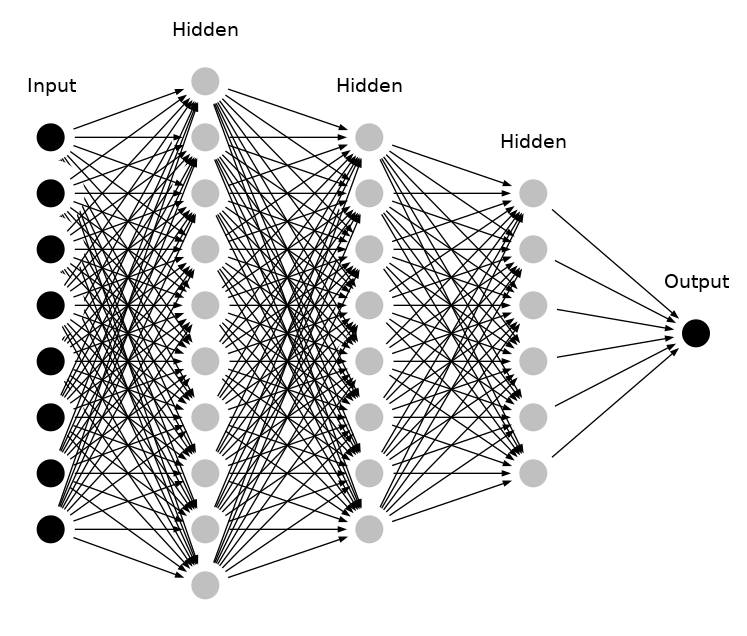

In [90]:
plot_neural_net(dummy_model)

ATTENTION: Pour des grandes tailles de reseau, cette visualisation n'est pas adaptée et le temps d'éxécution de cette fonction sera très long !

<font color='green'>
    
**Défi !** : 
* Créez vous un reseau de neurones en forme de noeud papillon, dont la couche de sortie fait la même dimension que la couche d'entrée.

</font>

In [91]:
# votre new_keras_model à créer ici
model_noeud_papillon = None

In [92]:
#plot_neural_net(model_noeud_papillon)

Bravo ! Vous venez de créer un réseau de neurone d'une classe très particulière: c'est un autoencoder !
Pour les curieux, vous pouvez retrouver le bestiaire des réseaux de neurones ici: https://rte-france.knowledgeplaza.net/tile/view/47639/

## IV) Un premier modèle de réseau de neurones : variables calendaires + lag conso

## Choix des variables explicatives

pour ce TP, nous avons un jeu d'entrée X contenant beaucoup de variables. Afin de commencer par un modèle simple, nous allons élaguer ce X pour réduire le nombre de features en entrée. Dans ce TP, nous allons donc lister les colonnes à retirer des datasets X initialisés ci-dessus.

Pour un cas d'étude réel, une approche pragmatique serait de commencer par se créer un premier X simple, de voir les performances du modèle, puis ensuite d'incorporer de plus en plus de features dans le X pour évaluer la progression des performances de nos modèles.

Toutefois, en deep learning, il est courant commencer directement en mettant en entrée toute l'information disponible. En effet une des forces des réseaux de neurones est leur capacité à "digérer" la donnée, en se nourrissant d'informations redondantes.

pour des raisons pédagogiques, nous allons commencer avec la première approche.

Pour le premier réseau de neurones que nous allons entrainer, nous allons simplement garder les variables calendaires ainsi que la valeur de consommation nationale réalisée la veille.

In [93]:
# Petit rappel pour se remettre en mémoire les variables que nous avons à disposition
X_train_full.head()

,ds,is_bank_holiday,Th_real_24h_avant_scaled,Th_prev_scaled,conso_nat_realisee_scaled_lag1H,conso_nat_realisee_scaled_lag1D,conso_nat_realisee_scaled_lag1W,month_1,month_2,month_3,...,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,weekday
0,2014-01-15 00:00:00,0,-1.131248,-1.265995,1.397540,1.043923,0.675608,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2014-01-15 01:00:00,0,-1.161552,-1.264590,1.289918,0.671384,0.277725,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2014-01-15 02:00:00,0,-1.180329,-1.252592,0.893387,0.589611,0.186322,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,2014-01-15 03:00:00,0,-1.193280,-1.245357,0.804434,0.419392,-0.024615,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,2014-01-15 05:00:00,0,-1.246823,-1.256132,0.460701,0.295634,-0.162817,1,0,0,...,0,0,0,0,0,0,0,0,0,1


Sélectionnons un sous-ensemble de ces variables

In [94]:
x_cols_to_keep = ['conso_nat_realisee_scaled_lag1D'] \
+ ["month_" + str(x) for x in range(1, 13)] \
+ ["hour_" + str(x) for x in range(0, 24)] \
+ ["weekday"]

y_cols_to_keep = ["conso_nat_realisee_scaled"]

On restreint nos jeux d'entrainement et de tests à ces variables

In [95]:
X_train = X_train_full[x_cols_to_keep]
X_validation = X_validation_full[x_cols_to_keep]
X_test = X_test_full[x_cols_to_keep]

Y_train = Y_train_full[y_cols_to_keep]
Y_validation = Y_validation_full[y_cols_to_keep]
Y_test = Y_test_full[y_cols_to_keep]

In [96]:
# Après élagage des variables
print(X_train.columns)

print(X_train.shape)
print(X_validation.shape)
print(X_test.shape)

Index(['conso_nat_realisee_scaled_lag1D', 'month_1', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12', 'hour_0', 'hour_1', 'hour_2',
       'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9',
       'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15',
       'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21',
       'hour_22', 'hour_23', 'weekday'],
      dtype='object')
(30601, 38)
(3383, 38)
(9216, 38)


## Création du réseau de neurones et hyper-paramétrage
Un réseau de neurones profond est constuitué d'un certains nombre de couches, chacune portant un certain nombre de neurones. Ce sont 2 hyperparamètres que vous pouvez faire varier et qui vous permettront d'obtenir un apprentissage plus ou moins précis, en utilisant plus ou moins de puissance de calcul.

Le "learning rate" de l'optimiseur est également un hyperparamètre qui influencera la convergence et la vitesse de convergence de l'apprentissage, où l'on cherche à optimiser notre modèle pour minimiser l'erreur de prédiction. 

In [97]:
n_inputs = X_train.shape[1]  #nombre de features en entrée du réseau de neurones
n_outputs = 1
hidden_layers = [n_inputs, n_inputs, n_inputs, n_inputs, n_inputs]

first_model = new_keras_model(n_inputs, n_outputs, hidden_layers)

In [98]:
# on affiche le nombre de paramètres de ce modèle avec la fonction summary de Keras
first_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 38)                1482      
_________________________________________________________________
dense_22 (Dense)             (None, 38)                1482      
_________________________________________________________________
dense_23 (Dense)             (None, 38)                1482      
_________________________________________________________________
dense_24 (Dense)             (None, 38)                1482      
_________________________________________________________________
dense_25 (Dense)             (None, 38)                1482      
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 39        
Total params: 7,449
Trainable params: 7,449
Non-trainable params: 0
____________________________________________________

In [99]:
first_model.compile(
    loss='mean_squared_error', 
    optimizer=Adam(lr=0.01), 
)

In [100]:
# On crée ici une instance de l'utilitaire tensorboard qui va nous permettre de visualiser 
# les courbes d'apprentissage de nos différents modèles.
# On reviendra avec plus d'explication sur TensorBoard un peu plus tard.
# Donner un nom a votre modele pour le retrouver dans les logs tensorboard
model_name = "my_first_model_" + datetime.datetime.now().strftime("%H-%M-%S")
tensorboard = TensorBoard(log_dir="logs/{}".format(model_name))

## Entrainement

La cellule suivante peut prendre un peu de temps à s'exécuter. On reconnait là la méthode **fit** commune à chaque modèle de machine-learning pour entraîner son modèle.

In [101]:
# Paramètres d'appel
# - epoch: on précise le nombre d'epochs (le nombre de fois que l'on voit le jeu d'apprentissage en entier)
# - batch size: le nombre d'exemples sur lequel on fait un "pas" d'apprentissage parmi tout le jeu
# - validation_split: la proportion d'exemples que l'on conserve pour notre jeu de validation
# - callbacks: pour appeler des utilitaires/fonctions externes pour récupérer des résultats
first_model.fit(
    X_train, 
    Y_train, 
    epochs=100, 
    batch_size=100, 
    validation_data=(X_validation, Y_validation),
    callbacks=[tensorboard]
)

Train on 30601 samples, validate on 3383 samples
Epoch 1/100
30601/30601 [==============================] - 1s 20us/step - loss: 0.0717 - val_loss: 0.0636
Epoch 2/100
30601/30601 [==============================] - 0s 12us/step - loss: 0.0500 - val_loss: 0.0722
Epoch 3/100
30601/30601 [==============================] - 0s 12us/step - loss: 0.0491 - val_loss: 0.0613
Epoch 4/100
30601/30601 [==============================] - 0s 12us/step - loss: 0.0479 - val_loss: 0.0564
Epoch 5/100
30601/30601 [==============================] - 0s 12us/step - loss: 0.0475 - val_loss: 0.0487
Epoch 6/100
30601/30601 [==============================] - 0s 12us/step - loss: 0.0461 - val_loss: 0.0515
Epoch 7/100
30601/30601 [==============================] - 0s 12us/step - loss: 0.0458 - val_loss: 0.0511
Epoch 8/100
30601/30601 [==============================] - 0s 12us/step - loss: 0.0455 - val_loss: 0.0514
Epoch 9/100
30601/30601 [==============================] - 0s 12us/step - loss: 0.0459 - val_loss: 0.04

30601/30601 [==============================] - 0s 13us/step - loss: 0.0405 - val_loss: 0.0463
Epoch 78/100
30601/30601 [==============================] - 0s 13us/step - loss: 0.0403 - val_loss: 0.0558
Epoch 79/100
30601/30601 [==============================] - 0s 12us/step - loss: 0.0400 - val_loss: 0.0449
Epoch 80/100
30601/30601 [==============================] - 0s 12us/step - loss: 0.0401 - val_loss: 0.0457
Epoch 81/100
30601/30601 [==============================] - 0s 12us/step - loss: 0.0402 - val_loss: 0.0450
Epoch 82/100
30601/30601 [==============================] - 0s 12us/step - loss: 0.0401 - val_loss: 0.0458
Epoch 83/100
30601/30601 [==============================] - 0s 12us/step - loss: 0.0402 - val_loss: 0.0478
Epoch 84/100
30601/30601 [==============================] - 0s 12us/step - loss: 0.0402 - val_loss: 0.0456
Epoch 85/100
30601/30601 [==============================] - 0s 12us/step - loss: 0.0401 - val_loss: 0.0465
Epoch 86/100
30601/30601 [========================

<font color='green'>

* D'après les informations de logs exposées ici, quelle semble être la perfomance atteinte par votre réseau de neurones ? 

</font>

# Tensorboard
c'est un utilitaire de tensorflow qui permet de visualiser en temps réel les courbes d'apprentissage des réseau de neurones et est donc utile pour arrêter l'apprentissage si les progrès sont faibles.

En particulier, vous pouvez vous intéresser à la courbe de l'erreur (loss) d'entrainement et de validation pour visualiser la progression de l'apprentissage et une tendance au surapprentissage en fin d'apprentissage.

<img src="pictures/CourbesTensorboard.png" width=1000 height=60>

**Pour ouvrir une fenêtre tensorboard, revenez sur la page d'accueil de Jupyter, placez vous dans le dossier logs dans lequel se trouve les logs de vos entrainement, puis cliquez sur New (en haut à droite) et enfin sur Tensorboard**.

Une fenêtre pop-up doit s'ouvrir. Si elle est bloquée, autorisez son ouverture.

<font color='green'>

* Vous devriez visualiser les courbes de 2 modèles: celui que vous venez d'entrainer et un modèle qui avait été entrainé de la même manière mais avec des données non normalisée. Que constatez-vous ? Comment l'expliquez-vous ?

</font>

## Evaluation de la qualité du modèle

In [102]:
predictions_train_scaled = first_model.predict(X_train).reshape(-1)
predictions_val_scaled = first_model.predict(X_validation).reshape(-1)
predictions_test_scaled = first_model.predict(X_test).reshape(-1)

predictions_train = scaler_conso_nat.inverse_transform(predictions_train_scaled)
predictions_val = scaler_conso_nat.inverse_transform(predictions_val_scaled)
predictions_test = scaler_conso_nat.inverse_transform(predictions_test_scaled)

print(predictions_test)

[71454.12 67154.15 66580.23 ... 70694.38 67219.67 69101.15]


In [103]:
relative_error_on_train = np.abs((Y_train_full['conso_nat_realisee'] - predictions_train) / Y_train_full['conso_nat_realisee'])
mean_error_on_train = np.mean(relative_error_on_train)
max_error_on_train = np.max(relative_error_on_train)
rmse = np.sqrt(mean_squared_error(Y_train_full['conso_nat_realisee'], predictions_train))

print("Erreur moyenne sur le jeu de train : " + str(mean_error_on_train * 100) + " %")
print("Erreur max sur le jeu de train : " + str(max_error_on_train * 100) + " %")
print("RMSE : " + str(rmse) + " MW")

Erreur moyenne sur le jeu de train : 3.3877932905994528 %
Erreur max sur le jeu de train : 45.132891839841434 %
RMSE : 2461.752648175831 MW


In [104]:
relative_error_on_val = np.abs((Y_validation_full['conso_nat_realisee'] - predictions_val) / Y_validation_full['conso_nat_realisee'])
mean_error_on_val = np.mean(relative_error_on_val)
max_error_on_val = np.max(relative_error_on_val)
rmse = np.sqrt(mean_squared_error(Y_validation_full['conso_nat_realisee'], predictions_val))

print("Erreur moyenne sur le jeu de test : " + str(mean_error_on_val * 100) + " %")
print("Erreur max sur le jeu de test : " + str(max_error_on_val * 100) + " %")
print("RMSE : " + str(rmse) + " MW")

Erreur moyenne sur le jeu de test : 3.6318855830916665 %
Erreur max sur le jeu de test : 32.59134814112384 %
RMSE : 2667.8243037096513 MW


In [105]:
relative_error_on_test = np.abs((Y_test_full['conso_nat_realisee'] - predictions_test) / Y_test_full['conso_nat_realisee'])
mean_error_on_test = np.mean(relative_error_on_test)
max_error_on_test = np.max(relative_error_on_test)
rmse = np.sqrt(mean_squared_error(Y_test_full['conso_nat_realisee'], predictions_test))

print("Erreur moyenne sur le jeu de test : " + str(mean_error_on_test * 100) + " %")
print("Erreur max sur le jeu de test : " + str(max_error_on_test * 100) + " %")
print("RMSE : " + str(rmse) + " MW")

Erreur moyenne sur le jeu de test : 3.747952124343183 %
Erreur max sur le jeu de test : 50.346927966101696 %
RMSE : 2976.2912898251498 MW


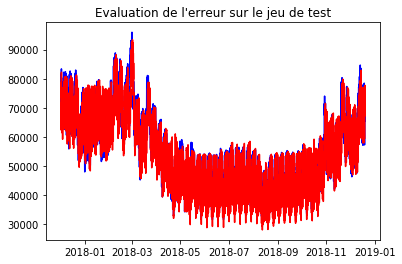

In [106]:
plt.plot(Y_test_full['ds'], Y_test_full['conso_nat_realisee'], 'b')
plt.plot(Y_test_full['ds'], predictions_test, 'r')

plt.title("Evaluation de l'erreur sur le jeu de test")
plt.show()

L'erreur est ici comparable à celle des autres modèles en machine Learning (random forest, xgboost). Cela peut nous conforter dans le fait que notre réseau de neurones s'est créé de bonnes représentations pour ces variables calendaires. 

La différence en performance peut devenir plus flagrante lorsque l'on intègre des variables à une maille très granulaire (les pixels d'une images, la température dans toutes les villes de France) avec une forte interdépendance.

Pour inspecter dynamiquement des visualisations, la librairie plotly se révèle très utile.
Ci-dessous vous pouvez identifier les jours et heures qui présentent les erreurs les plus importantes pour ensuite imaginer ce qui a pu pêcher.

In [107]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot, iplot_mpl
init_notebook_mode(connected=True)

iplot([{"x": Y_test_full['ds'], "y": relative_error_on_test}])

<font color='green'>

* Quelles sont les heures ou les journées avec les erreurs les plus importantes. Avez-vous une idée à quoi pourrait correspondre ces heures ou ces jours ?

</font>

# V) A vous de jouer, faites fonctionner vos neurones naturels

Il peut y avoir différents objectifs de performance selon le besoin. En général on cherche un compromis entre la précision du modèle et la puissance de calcul nécessaire pour entraîner et faire tourner ce modèle.

Nous décernerons 2 récompenses!

- Défi 1: le modèle le plus précis.
- Défi 2: le modèle le plus frugal moyennant une perte de précision.
Les critères sont encore à affiner ensemble!

<img src="pictures/we-need-you.png" width=500 height=60>



# **Challenge**: entrainez et testez votre nouveau modèle avec de nouvelles variables et paramètres choisies

N'hésitez pas à vous inspirer par le code ci-dessus ;-)
venez partager vos investigations sur cette google sheet : https://docs.google.com/spreadsheets/d/1oIx8jjzIh7Ugp3ZJMCOEwns6KCJxo4ua_jW5hIvjjFI/edit?usp=sharing

Quelques idées si vous n'êtes pas inspirés :
- essayer d'autres hyperparamètres (learning rate, taille des minibatch, nombre de couches...)
- regarder ce qu'il se passe si on utilise des variables non normalisées
- ajouter d'autres variables en entrée

# Votre modèle

## Rappel des variables explicatives à disposition

In [108]:
# Initialement
X_train_full.columns.get_values()

/home/clementrem/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning:

The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.



array(['ds', 'is_bank_holiday', 'Th_real_24h_avant_scaled',
       'Th_prev_scaled', 'conso_nat_realisee_scaled_lag1H',
       'conso_nat_realisee_scaled_lag1D',
       'conso_nat_realisee_scaled_lag1W', 'month_1', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12', 'hour_0', 'hour_1', 'hour_2',
       'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8',
       'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14',
       'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20',
       'hour_21', 'hour_22', 'hour_23', 'weekday'], dtype=object)

## Choix des variables explicatives

On sélectionne les variables que l'on souhaite conserver en précisant simplement à quelle catégorie elles appartiennent.

In [109]:
#########
#TO DO
x_cols_to_keep = ['conso_nat_realisee_scaled_lag1D'] \
+ ["month_" + str(x) for x in range(1, 13)] \
+ ["hour_" + str(x) for x in range(0, 24)] \
+ ["weekday"]

y_cols_to_keep = ["conso_nat_realisee_scaled"]  # <= pas la peine d'y toucher
#########

In [110]:
X_train = X_train_full[x_cols_to_keep]
X_validation = X_validation_full[x_cols_to_keep]
X_test = X_test_full[x_cols_to_keep]

Y_train = Y_train_full[y_cols_to_keep]
Y_validation = Y_validation_full[y_cols_to_keep]
Y_test = Y_test_full[y_cols_to_keep]

In [111]:
# Après élagage des variables
print(X_train.columns)

print(X_train.shape)
print(X_validation.shape)
print(X_test.shape)

Index(['conso_nat_realisee_scaled_lag1D', 'month_1', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12', 'hour_0', 'hour_1', 'hour_2',
       'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9',
       'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15',
       'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21',
       'hour_22', 'hour_23', 'weekday'],
      dtype='object')
(30601, 38)
(3383, 38)
(9216, 38)


## Création du réseau de neurones, hyper-paramétrage

Vous pouvez jouer sur l'architecture de votre reseau de neurones ici en précisant le nombre de couches et la taille des couches dans le vecteur hiddenLayers

In [112]:
n_inputs = X_train.shape[1]  # nombre d'entrées du modèle
n_outputs = 1

## votre choix !
hidden_layers = [n_inputs, n_inputs, n_inputs, n_inputs, n_inputs]
##

mon_reseau_de_neurones = new_keras_model(n_inputs, n_outputs, hidden_layers)

In [113]:
# on affiche le nombre de paramètres de votre modèle avec la fonction summary de Keras
mon_reseau_de_neurones.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 38)                1482      
_________________________________________________________________
dense_28 (Dense)             (None, 38)                1482      
_________________________________________________________________
dense_29 (Dense)             (None, 38)                1482      
_________________________________________________________________
dense_30 (Dense)             (None, 38)                1482      
_________________________________________________________________
dense_31 (Dense)             (None, 38)                1482      
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 39        
Total params: 7,449
Trainable params: 7,449
Non-trainable params: 0
____________________________________________________

In [114]:
mon_reseau_de_neurones.compile(
    loss='mean_squared_error', 
    optimizer=Adam(lr=0.01),
)

# Tensorboard
Notre utilitaire de tensorflow qui permet de visualiser en temps réel les courbes d'apprentissage des réseau de neurones et est donc utile pour arrêter l'apprentissage si les progrès sont faibles.

In [115]:
# Donner un nom a votre modele pour le retrouver dans les logs tensorboard
model_name = "my_own_model_" + datetime.datetime.now().strftime("%H-%M-%S")
tensorboard = TensorBoard(log_dir="logs/{}".format(model_name))

## Entrainement

La cellule suivante peut prendre un peu de temps à s'exécuter.

In [116]:
mon_reseau_de_neurones.fit(
    X_train, 
    Y_train, 
    epochs=100, 
    batch_size=100, 
    validation_data=(X_validation, Y_validation),
    callbacks=[tensorboard]
)

Train on 30601 samples, validate on 3383 samples
Epoch 1/100
30601/30601 [==============================] - 1s 21us/step - loss: 0.0736 - val_loss: 0.0760
Epoch 2/100
30601/30601 [==============================] - 0s 12us/step - loss: 0.0528 - val_loss: 0.0559
Epoch 3/100
30601/30601 [==============================] - 0s 12us/step - loss: 0.0488 - val_loss: 0.0491
Epoch 4/100
30601/30601 [==============================] - 0s 12us/step - loss: 0.0485 - val_loss: 0.0630
Epoch 5/100
30601/30601 [==============================] - 0s 12us/step - loss: 0.0464 - val_loss: 0.0506
Epoch 6/100
30601/30601 [==============================] - 0s 12us/step - loss: 0.0466 - val_loss: 0.0480
Epoch 7/100
30601/30601 [==============================] - 0s 12us/step - loss: 0.0461 - val_loss: 0.0466
Epoch 8/100
30601/30601 [==============================] - 0s 12us/step - loss: 0.0452 - val_loss: 0.0519
Epoch 9/100
30601/30601 [==============================] - 0s 12us/step - loss: 0.0452 - val_loss: 0.04

30601/30601 [==============================] - 0s 11us/step - loss: 0.0400 - val_loss: 0.0475
Epoch 78/100
30601/30601 [==============================] - 0s 11us/step - loss: 0.0402 - val_loss: 0.0468
Epoch 79/100
30601/30601 [==============================] - 0s 12us/step - loss: 0.0399 - val_loss: 0.0447
Epoch 80/100
30601/30601 [==============================] - 0s 12us/step - loss: 0.0404 - val_loss: 0.0454
Epoch 81/100
30601/30601 [==============================] - 0s 12us/step - loss: 0.0405 - val_loss: 0.0464
Epoch 82/100
30601/30601 [==============================] - 0s 11us/step - loss: 0.0401 - val_loss: 0.0515
Epoch 83/100
30601/30601 [==============================] - 0s 11us/step - loss: 0.0404 - val_loss: 0.0531
Epoch 84/100
30601/30601 [==============================] - 0s 12us/step - loss: 0.0406 - val_loss: 0.0498
Epoch 85/100
30601/30601 [==============================] - 0s 12us/step - loss: 0.0409 - val_loss: 0.0473
Epoch 86/100
30601/30601 [========================

## Evaluation de la qualité du modèle

In [117]:
predictions_test_scaled = mon_reseau_de_neurones.predict(X_test).reshape(-1)
predictions_test = scaler_conso_nat.inverse_transform(predictions_test_scaled)

print(predictions_test)

[71267.94 67187.98 66323.7  ... 70594.99 67195.43 69692.42]


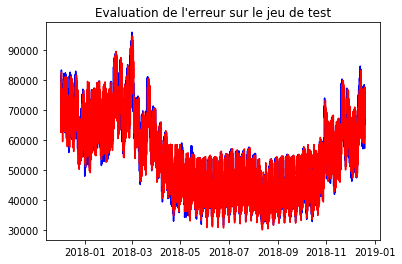

In [118]:
plt.plot(Y_test_full['ds'], Y_test_full['conso_nat_realisee'], 'b')
plt.plot(Y_test_full['ds'], predictions_test, 'r')

plt.title("Evaluation de l'erreur sur le jeu de test")
plt.show()

In [119]:
relative_error_on_train = np.abs((Y_train_full['conso_nat_realisee'] - predictions_train) / Y_train_full['conso_nat_realisee'])
mean_error_on_train = np.mean(relative_error_on_train)
max_error_on_train = np.max(relative_error_on_train)
rmse = np.sqrt(mean_squared_error(Y_train_full['conso_nat_realisee'], predictions_train))

print("Erreur moyenne sur le jeu de train : " + str(mean_error_on_train * 100) + " %")
print("Erreur max sur le jeu de train : " + str(max_error_on_train * 100) + " %")
print("RMSE : " + str(rmse) + " MW")

Erreur moyenne sur le jeu de train : 3.3877932905994528 %
Erreur max sur le jeu de train : 45.132891839841434 %
RMSE : 2461.752648175831 MW


In [120]:
relative_error_on_val = np.abs((Y_validation_full['conso_nat_realisee'] - predictions_val) / Y_validation_full['conso_nat_realisee'])
mean_error_on_val = np.mean(relative_error_on_val)
max_error_on_val = np.max(relative_error_on_val)
rmse = np.sqrt(mean_squared_error(Y_validation_full['conso_nat_realisee'], predictions_val))

print("Erreur moyenne sur le jeu de test : " + str(mean_error_on_val * 100) + " %")
print("Erreur max sur le jeu de test : " + str(max_error_on_val * 100) + " %")
print("RMSE : " + str(rmse) + " MW")

Erreur moyenne sur le jeu de test : 3.6318855830916665 %
Erreur max sur le jeu de test : 32.59134814112384 %
RMSE : 2667.8243037096513 MW


In [121]:
relative_error_on_test = np.abs((Y_test_full['conso_nat_realisee'] - predictions_test) / Y_test_full['conso_nat_realisee'])

mean_error_on_test = np.mean(relative_error_on_test)
max_error_on_test = np.max(relative_error_on_test)
rmse = np.sqrt(mean_squared_error(Y_test_full['conso_nat_realisee'], predictions_test))

print("Erreur moyenne sur le jeu de test : " + str(mean_error_on_test * 100) + " %")
print("Erreur max sur le jeu de test : " + str(max_error_on_test * 100) + " %")
print("RMSE : " + str(rmse) + " MW")

Erreur moyenne sur le jeu de test : 3.251037968457973 %
Erreur max sur le jeu de test : 35.65011900814702 %
RMSE : 2801.394478341903 MW


In [122]:
iplot([{"x": Y_test_full['ds'], "y": relative_error_on_test}])

# Pour aller encore plus loin

Le modèle ci-dessus peut être rendu encore plus performant par exemple en considérant des features comme "jour d'avant vacances", "jour d'après vacances"... 

Passer du temps à tuner les hyper-paramètres serait certainement bénéfique aussi.

De manière assez surprenante, élargir le réseau de neurones pour prédire les consommations régionales peut également améliorer la qualité de la prédiction de l'échelle nationale. C'est l'idée du multi-tasking.

On pourra également considérer en sortie du modèle non pas la prédiction pour juste 24 heures plus tard, mais plutôt pour une plage horaire  
[1 heure plus tard, ..., 24 heures plus tard]. Ceci permet de capter des dynamiques.


Des pistes:
insérer le lag Jours_Feries_J-1
voir si un intérêt à passer toutes les stations ou seulement la température France avec expertise sur importance des stations (en fait ça suffit avec les stations fournies!)


## Exemple d apprentissage avec differentes variables


Voici quelques exemples de courbes d'apprentissage. 

<font color='green'>

* Que pensez-vous de la courbe rose ?

</font>

<img src="pictures/ResultsApprentissages.png" width=500 height=50>